# HUMAN FACE GENERATION USING DCGAN

## <pre>STEP 1 : Loading & Preprocessing the Data

In [30]:
import os
import tensorflow as tf
import numpy as np
from PIL import Image
import time
from IPython import display
import zipfile
import random
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
DATA_DIR = '/kaggle/input/flickr-faces-dataset-resized/64x64/faces'

In [8]:
# SET IMAGE PARAMETERS
IMG_SIZE = 64
BUFFER_SIZE = 50000
BATCH_SIZE = 200

<pre> DATA PREPROCESSING STEPS:

1. Access images from base directory
2. Convert the images to RGB explicitly
3. Resize images
4. Convert their dtype explicitly to float
5. Normalize the data  between (-1, 1) (For generator & Discriminator)
6. Append the images in the folder

- Generally we normalize the data between (0, 1) but as we are working with **`GAN's`**, we'll be normalizing it beween **`(-1, 1)`**
- GANs often work better when the input is normalized to a **`symmetrical range`** around zero
- This helps the generator and discriminator networks to train more effectively since the data is centered around zero.

- **`os.walk()`** is used to simplify traversing directories and files.
- Processes all files within subdirectories and skips directories automatically.


In [9]:
def load_images(directory, img_size):
    images = []
    for subdir, _, files in os.walk(directory):
      for file in files:
        # STEP 1
        file_path = os.path.join(subdir, file)
        try:
          # STEP 2
          img = Image.open(file_path).convert('RGB')
          # STEP 3
          img = img.resize((img_size, img_size))
          # STEP 4
          img_array = np.array(img).astype('float32')
          # STEP 5
          img_array = (img_array - 127.5) / 127.5
          # STEP 6
          images.append(img_array)
        except Exception as e:
          pass
    return np.array(images)

images_data = load_images(DATA_DIR, IMG_SIZE)

In [10]:
len(images_data)

52001

In [11]:
images_data[0].shape

(64, 64, 3)

<pre>1. Convert the images to a Tensorflow dataset
2. Shuffle and batch the dataset

**`Shuffling`** ensures that each mini-batch of data presented to the model during training is representative of the entire dataset, reducing the risk of the model learning biases based on the order of the samples.


In [12]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(images_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [13]:
type(train_dataset)

tensorflow.python.data.ops.batch_op._BatchDataset

## <pre> STEP 2. VISUALIZING THE DATASET

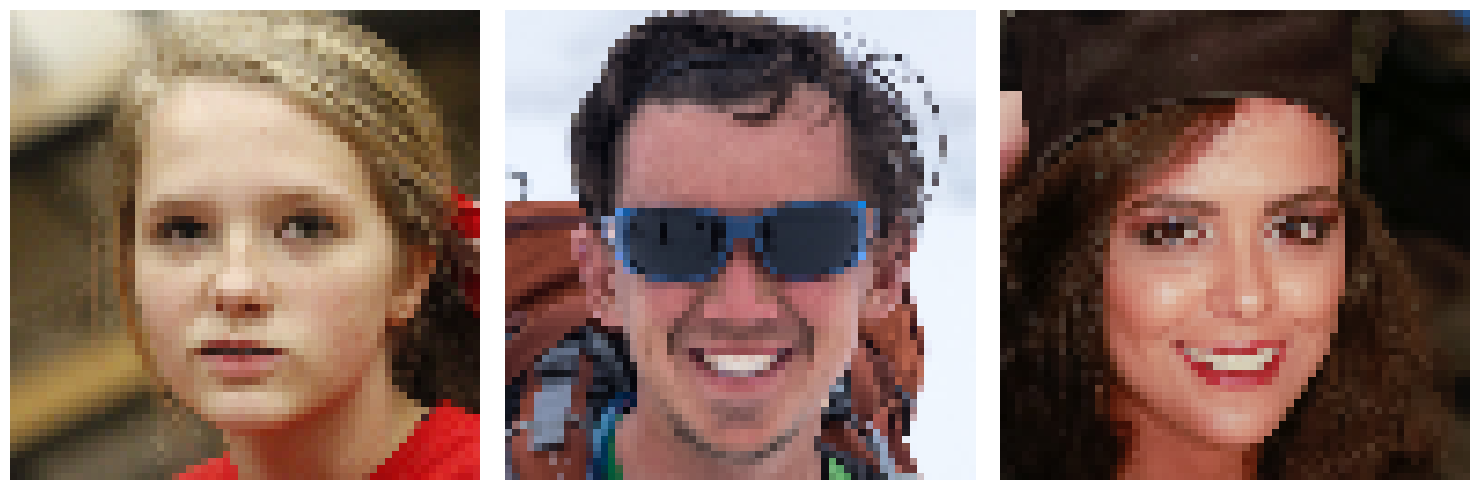

In [14]:
img_files = os.listdir(DATA_DIR)[:3]

#CREATING A SUBPLOT
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, img_file in enumerate(img_files):
    img_path = os.path.join(DATA_DIR, img_file)
    
    # Open the image file
    img = Image.open(img_path)
    
    # Display the image
    axes[i].imshow(img)
    axes[i].axis('off') 
    
plt.tight_layout()

## <pre>STEP 3 : Creating the Models - Generator & Discriminator

- A **`generator`** ("the artist") learns to create images that look real, while a **`discriminator`** ("the art critic") learns to tell real images apart from fakes.
- During training, the **`generator`** progressively becomes better at creating images that look real, while the **`discriminator`** becomes better at telling them apart
- The process reaches equilibrium when the **`discriminator`** can no longer distinguish real images from fakes.

`Generator & Discriminator will be 2 seprate neural networks`

### <pre> GENERATOR

- The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a seed (random noise)
- Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of 64x64x3
- LeakyReLU activation for each layer, except the output layer which uses tanh.

<pre>DENSE LAYER
1. Spatial Dimension - 8 x 8
2. Channel Depth - 512 </pre>
**`Latent Vector = (8, 8, 512)`**

<pre>TRANSPOSED CONVOLUTIONS:
1. Upsample from 8x8 to 16x16: 256 channels.
2. Upsample from 16x16 to 32x32: 128 channels.
3. Upsample from 32x32 to 64x64: 64 channels.

<pre>FINAL LAYER
Produces a 64x64x3 image (3 channels for RGB).

In [15]:
LATENT_DIM = 100

def generator_model():
    model = tf.keras.Sequential([
        # 1. Dense Layer of Random Noise
        tf.keras.layers.Dense(8*8*512, input_dim = LATENT_DIM, activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        
        # 2. convert 1D to 3D
        tf.keras.layers.Reshape((8, 8, 512)),
        
        # 3. FIRST TRANSPOSED CONVOLUTION (Upsample to 16 x 16)
        tf.keras.layers.Conv2DTranspose(filters = 256, kernel_size = (4, 4), strides = (2, 2), padding = 'same', activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        
        # 4. SECOND TRANSPOSED CONVOLUTION (Upsample to 32 x 32)
        tf.keras.layers.Conv2DTranspose(filters = 128, kernel_size = (4, 4), strides = (2, 2), padding = 'same', activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        
        # 5. THIRD TRANSPOSED CONVOLUTION (Upsample to 64 x 64)
        tf.keras.layers.Conv2DTranspose(filters = 64, kernel_size = (4, 4), strides = (2, 2), padding = 'same', activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        
        # 6. FINAL LAYER
        tf.keras.layers.Conv2D(3, kernel_size = (4, 4), padding = 'same', activation = 'tanh')
    ])
    return model

generator = generator_model()

In [16]:
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32768)          │     3,309,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32768)          │       131,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 256)    │     2,097,408 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 3)      │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,198,467 (23.65 MB)

 Trainable params: 6,132,035 (23.39 MB)

 Non-trainable params: 66,432 (259.50 KB)

### <pre> DISCIMINATOR

The discriminator is a CNN-based image classifier.

In [17]:
INPUT_SHAPE = (64, 64, 3)

def discriminator_model():
    model = tf.keras.Sequential([
        # 1. FIRST CONV 2D LAYER
        tf.keras.layers.Conv2D(64, kernel_size = (4, 4), strides = (2, 2), padding = 'same', input_shape = INPUT_SHAPE),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        
        # 2. SECOND CONV 2D LAYER
        tf.keras.layers.Conv2D(128, kernel_size = (4, 4), strides = (2, 2), padding = 'same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        
        # 3. THIRD CONV 2D LAYER
        tf.keras.layers.Conv2D(256, kernel_size = (4, 4), strides = (2, 2), padding = 'same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        
        # 4. FLATTENING & DROPOUT LAYER
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        
        # 5. OUTPUT LAYER
        tf.keras.layers.Dense(1, activation = 'sigmoid')
    ])
    return model

discriminator = discriminator_model()


**`1`** - Output is kept as 1 for **`Binary Classification`**, where the output can be used to differentiate between real and generated images.

In [18]:
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        16,385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 677,057 (2.58 MB)

 Trainable params: 676,161 (2.58 MB)

 Non-trainable params: 896 (3.50 KB)

## <pre>STEP 4 : Define Loss & Optimizers - Generator Loss & Discriminator Loss

Defining **`loss functions`** and **`optimizers`** for both models.


We're using **`BinaryCrossentropy`** as our loss function, as the discriminator will have either of two (binary) output -> Determining whether the generated image by Generator is **`real`** or **`fake`**

In [19]:

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

### <pre> DISCIMINATOR LOSS
This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [20]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### <pre> GENERATOR LOSS
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [21]:

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

### <pre> OPTIMIZERS

**`Generator`** & **`Discriminator`** both will have different optimizers as we're training both models seperately<br>
Using **`Adam`** optimizer

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=(1e-4))
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=(1e-4))

## <pre>STEP 5 : Defining the Training Loop

In [23]:
EPOCHS = 60
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

- The training loop begins with generator receiving a random seed as input.
- That seed is used to produce an image.
- The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator).
- The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [24]:
# Training functions
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

#### **Generate and save images**


In [25]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    predictions = (predictions + 1) / 2.0

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.close()

In [26]:
def train(dataset, epochs):
    for epoch in range(epochs):
        print(f'Starting epoch {epoch+1}/{epochs}')
        for image_batch in dataset:
            train_step(image_batch)
        generate_and_save_images(generator, epoch + 1, seed)  # Use the generator model, not the function

#### **Training the model**


In [27]:
train(train_dataset, EPOCHS)

Starting epoch 1/60
Starting epoch 2/60
Starting epoch 3/60
Starting epoch 4/60
Starting epoch 5/60
Starting epoch 6/60
Starting epoch 7/60
Starting epoch 8/60
Starting epoch 9/60
Starting epoch 10/60
Starting epoch 11/60
Starting epoch 12/60
Starting epoch 13/60
Starting epoch 14/60
Starting epoch 15/60
Starting epoch 16/60
Starting epoch 17/60
Starting epoch 18/60
Starting epoch 19/60
Starting epoch 20/60
Starting epoch 21/60
Starting epoch 22/60
Starting epoch 23/60
Starting epoch 24/60
Starting epoch 25/60
Starting epoch 26/60
Starting epoch 27/60
Starting epoch 28/60
Starting epoch 29/60
Starting epoch 30/60
Starting epoch 31/60
Starting epoch 32/60
Starting epoch 33/60
Starting epoch 34/60
Starting epoch 35/60
Starting epoch 36/60
Starting epoch 37/60
Starting epoch 38/60
Starting epoch 39/60
Starting epoch 40/60
Starting epoch 41/60
Starting epoch 42/60
Starting epoch 43/60
Starting epoch 44/60
Starting epoch 45/60
Starting epoch 46/60
Starting epoch 47/60
Starting epoch 48/60
S

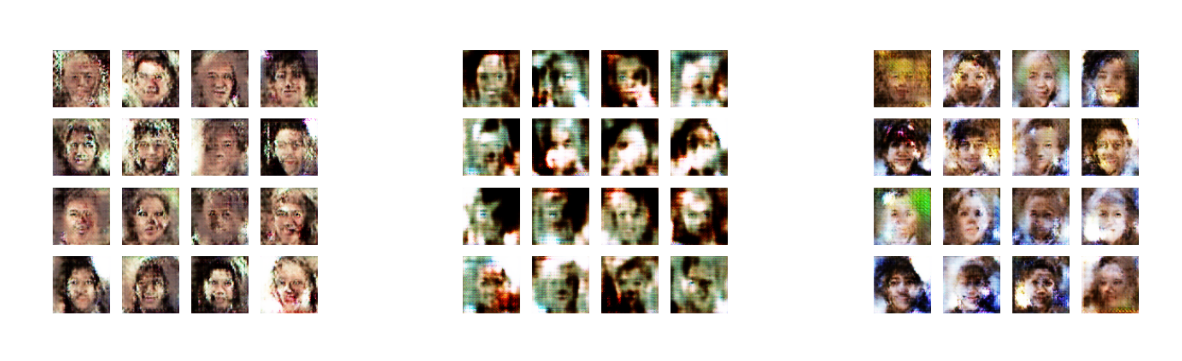

In [51]:
# VISUALIZING GENERATED IMAGES (ANY 3)

image_folder = '/kaggle/working/'

# Get a list of all image file paths in the folder
image_paths = [os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith(('.png', '.jpg', '.jpeg'))]

# Select 3 random images from the list
random_images = random.sample(image_paths, 3)

# Create a figure to display the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Display each random image
for ax, img_path in zip(axes, random_images):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')